# Conv1d_Autoencoder

In [1]:
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
import yaml
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from tqdm import tqdm


sys.path.append(os.path.abspath(os.path.join(os.getcwd(), os.path.pardir)))
import anomaly_detection.preprocess as preproc
from anomaly_detection.datasets import MimiiDue, ToyAdmos
from anomaly_detection.models.conv1d_AE import Conv1dAE


warnings.filterwarnings("ignore")

In [2]:
import torch
from torch import nn
from torch.autograd import Variable
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset, TensorDataset

## 1D Feature representation - amplitude values

### Dataset MIMII_DUE

In [3]:
# train data dir
target_dir = (
    r"C:\Users\alina\OneDrive\Документы\Диплом\datasets\MIMII_DUE\dev_data\gearbox"
)
section_name = "section_00"
dir_name_train = r"\train"
# target_test data dir
dir_name_test = r"\target_test"

In [4]:
dataset_train_mimii_ts = MimiiDue(
    target_dir, section_name, dir_name_train, extraction_type="amplitude"
)
dataset_test_mimii_ts = MimiiDue(
    target_dir, section_name, dir_name_test, extraction_type="amplitude"
)

100%|██████████| 204/204 [00:07<00:00, 28.87it/s]


In [5]:
# train and test from MIMII_DUE
X_train_mimii_ts, y_train_mimii_ts = (
    dataset_train_mimii_ts.data,
    dataset_train_mimii_ts.labels,
)
X_test_mimii_ts, y_test_mimii_ts = (
    dataset_test_mimii_ts.data,
    dataset_test_mimii_ts.labels,
)
X_train_mimii_ts.shape, X_test_mimii_ts.shape, y_train_mimii_ts.shape, y_test_mimii_ts.shape

((1004, 160000), (204, 160000), (1004,), (204,))

In [6]:
# Anomaly data ratio
contamination_mimii = np.round(y_test_mimii_ts.sum() / y_test_mimii_ts.shape, 2)
print(f"Mimii_due_anomaly ratio = {contamination_mimii[0]}")
contamination_mimii = 0.4

Mimii_due_anomaly ratio = 0.53


### Dataset ToyAdmos2

In [7]:
# data dir
target_dir_toyadm = r"C:\Users\alina\OneDrive\Документы\Диплом\datasets\ToyAdmos2"
dir_name_toyadm_anomaly = r"\toyad2_car_A_anomaly"
dir_name_toyadm_normal = r"\toyad2_car_A1_normal"

In [9]:
dataset_toy_ts = ToyAdmos(
    target_dir_toyadm,
    dir_name_toyadm_normal,
    dir_name_toyadm_anomaly,
    extraction_type="amplitude",
)

100%|██████████| 3545/3545 [12:03<00:00,  4.90it/s]


In [10]:
# Train - test - val stratified split
(
    X_train_toy_ts,
    X_test_toy_ts,
    X_val_toy_ts,
    y_train_toy_ts,
    y_test_toy_ts,
    y_val_toy_ts,
) = preproc.mix_data([dataset_toy_ts.data], [dataset_toy_ts.labels])
X_train_toy_ts.shape, X_test_toy_ts.shape, X_val_toy_ts.shape, y_train_toy_ts.shape, y_test_toy_ts.shape, y_val_toy_ts.shape

((2871, 192000), (319, 192000), (355, 192000), (2871,), (319,), (355,))

In [11]:
# Anomaly data ratio
contamination_toy = np.round(y_test_toy_ts.sum() / y_test_toy_ts.shape, 2)
print(f"ToyAdmos anomaly ratio = {contamination_toy[0]}")

ToyAdmos anomaly ratio = 0.23


In [12]:
torch.cuda.is_available()

True

In [13]:
def dataloader(X_train, y_train, X_test, y_test, batch_size):
    train_dataset = TensorDataset(
        torch.tensor(X_train.astype(np.float32)), torch.tensor(y_train.astype(np.long))
    )
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_dataset = TensorDataset(
        torch.tensor(X_test.astype(np.float32)), torch.tensor(y_test.astype(np.long))
    )
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    return train_loader, test_loader

In [14]:
def save_score_distribution(model, data_loader, criterion, figsize=(8, 6), epoch=0):
    """
    plot losses for normal and anomaly samples

    """
    losses = []
    labels = []
    for (x_batch, y_batch) in data_loader:
        x_batch = x_batch.cuda()

        output, enc = model(x_batch)
        loss = criterion(output, x_batch)
        loss = loss.reshape(loss.shape[0], loss.shape[2])
        loss = torch.mean(loss, dim=1)
        loss = loss.detach().cpu().numpy().flatten()
        losses.append(loss)
        labels.append(y_batch.detach().cpu().numpy().flatten())

    losses = np.concatenate(losses)
    labels = np.concatenate(labels)

    losses_0 = losses[labels == 0]
    losses_1 = losses[labels == 1]

    fig, ax = plt.subplots(1, figsize=figsize)

    ax.boxplot([losses_0, losses_1])
    ax.set_xticklabels(["normal", "anomaly"])
    if epoch in [0, 9, 49, 99]:
        plt.show()
    plt.close(fig)

In [15]:
# using difference between input & output we can get anomaly score
# (anomaly samples has higher difference between input and output then normal samples)
def get_difference_score(model, x, batch_size, extraction_type="melspectrogram"):
    """
    return:
       average difference between decoder output and input

    """
    dataset = TensorDataset(torch.tensor(x.astype(np.float32)))
    data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=False)

    predictions = []
    for (x_batch,) in data_loader:
        x_batch = x_batch.cuda()
        preds, enc = model(x_batch)
        predictions.append(preds.detach().cpu().numpy())

    predictions = np.concatenate(predictions)
    if extraction_type != "melspectrogram":
        predictions = predictions.reshape(predictions.shape[0], predictions.shape[2])
        x = x.reshape(x.shape[0], x.shape[2])
        diff = ((x**2 - predictions**2)).mean(axis=1).reshape(-1, 1)
    else:

        diff = (x.mean(axis=2) - predictions.mean(axis=2)).reshape(
            x.shape[0], x.shape[-1]
        )

    return diff

In [16]:
def autoencoder_test(
    X_train,
    X_test,
    X_val,
    y_train,
    y_test,
    y_val,
    batch_size=64,
    lr=1e-3,
    epochs=10,
    extraction_type="aggregate_MFCC",
):
    epochs = epochs
    input_size = X_test.shape[-1]
    model = Conv1dAE(input_size).cuda()
    criterion = nn.MSELoss()
    per_sample_criterion = nn.MSELoss(reduction="none")
    optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)

    X_train = X_train[:, np.newaxis, :]
    X_test = X_test[:, np.newaxis, :]
    X_val = X_val[:, np.newaxis, :]
    train_loader, test_loader = dataloader(X_train, y_train, X_test, y_test, batch_size)

    for epoch in range(epochs):
        running_loss = 0
        for (x_batch, _) in train_loader:
            x_batch = x_batch.cuda()

            output, enc = model(x_batch)
            loss = criterion(output[0], x_batch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print("epoch [{}/{}], train loss:{:.4f}".format(epoch + 1, epochs, running_loss))
        # if extraction_type != 'melspectrogram':
        save_score_distribution(model, test_loader, per_sample_criterion, epoch=epoch)

    # test_score = get_difference_score(
    #    model, X_test, batch_size, extraction_type=extraction_type)
    test_score = get_difference_score(
        model, X_test, batch_size, extraction_type=extraction_type
    )

    # using classification algorithms we can classify samples by outier score (difference between input and output)
    score_forest = RandomForestClassifier(max_features=100, random_state=0)
    score_forest.fit(test_score, y_test)

    # Classification report on Validation data
    val_score = get_difference_score(
        model, X_val, batch_size, extraction_type=extraction_type
    )

    print(
        preproc.pyod_classification_report(
            test_score,
            val_score,
            y_train,
            y_val,
            dataset="MIMII_DUE",
            extraction_type=extraction_type,
            contamination=contamination_mimii,
        )
    )

    prediction = score_forest.predict(val_score)
    accuracy = metrics.accuracy_score(y_val, prediction)
    precision = metrics.precision_score(y_val, prediction)
    recall = metrics.recall_score(y_val, prediction)
    f1_score = metrics.f1_score(y_val, prediction)
    scores = pd.DataFrame(
        [
            {
                "Extraction_type": extraction_type,
                "Model_name": "Autoencoder",
                "Accuracy": accuracy,
                "Precision": precision,
                "Recall": recall,
                "F1_score": f1_score,
            }
        ]
    )

    return scores

In [17]:
# train-test-val from MIMII_DUE_ts dataset
(
    X_train_mimii,
    X_test_mimii,
    X_val_mimii,
    y_train_mimii,
    y_test_mimii,
    y_val_mimii,
) = preproc.mix_data(
    [X_train_mimii_ts, X_test_mimii_ts], [y_train_mimii_ts, y_test_mimii_ts]
)

epoch [1/50], train loss:7.9446


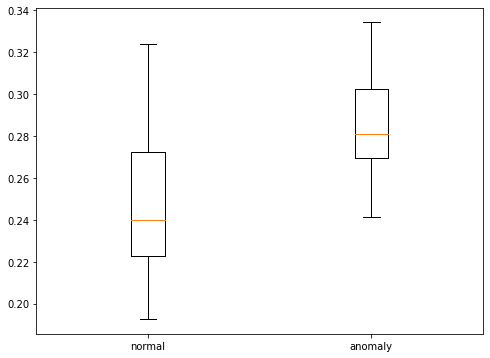

epoch [2/50], train loss:2.7931
epoch [3/50], train loss:1.0426
epoch [4/50], train loss:0.3726
epoch [5/50], train loss:0.1619
epoch [6/50], train loss:0.0733
epoch [7/50], train loss:0.0383
epoch [8/50], train loss:0.0238
epoch [9/50], train loss:0.0196
epoch [10/50], train loss:0.0175


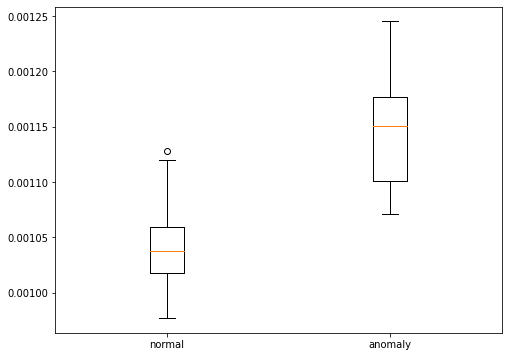

epoch [11/50], train loss:0.0165
epoch [12/50], train loss:0.0156
epoch [13/50], train loss:0.0152
epoch [14/50], train loss:0.0148
epoch [15/50], train loss:0.0145
epoch [16/50], train loss:0.0143
epoch [17/50], train loss:0.0141
epoch [18/50], train loss:0.0139
epoch [19/50], train loss:0.0138
epoch [20/50], train loss:0.0137
epoch [21/50], train loss:0.0137
epoch [22/50], train loss:0.0136
epoch [23/50], train loss:0.0136
epoch [24/50], train loss:0.0135
epoch [25/50], train loss:0.0135
epoch [26/50], train loss:0.0134
epoch [27/50], train loss:0.0134
epoch [28/50], train loss:0.0134
epoch [29/50], train loss:0.0133
epoch [30/50], train loss:0.0133
epoch [31/50], train loss:0.0133
epoch [32/50], train loss:0.0133
epoch [33/50], train loss:0.0133
epoch [34/50], train loss:0.0133
epoch [35/50], train loss:0.0133
epoch [36/50], train loss:0.0133
epoch [37/50], train loss:0.0134
epoch [38/50], train loss:0.0133
epoch [39/50], train loss:0.0133
epoch [40/50], train loss:0.0132
epoch [41/

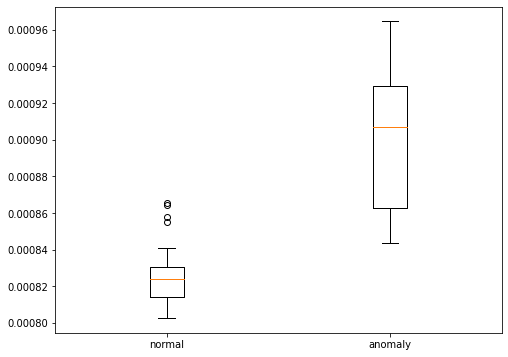

   F1_score Extraction_type  Accuracy    Recall    Dataset Model_name  \
0  0.237288       amplitude  0.628099  0.636364  MIMII_DUE    IForest   
0  0.350877       amplitude  0.694215  0.909091  MIMII_DUE        LOF   
0  0.555556       amplitude  0.933884  0.454545  MIMII_DUE      OCSVM   

   Precision  
0   0.145833  
0   0.217391  
0   0.714286  


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,amplitude,Autoencoder,0.933884,0.8,0.363636,0.5


In [18]:
# MIMII_DUE Anomaly detection using Autoencoders (amplitude)
mimii_AE_ts = autoencoder_test(
    X_train_mimii,
    X_test_mimii,
    X_val_mimii,
    y_train_mimii,
    y_test_mimii,
    y_val_mimii,
    batch_size=64,
    lr=1e-3,
    epochs=50,
    extraction_type="amplitude",
)
mimii_AE_ts

epoch [1/50], train loss:15.3196


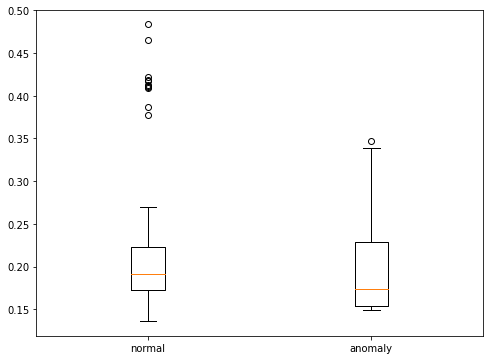

epoch [2/50], train loss:7.0590
epoch [3/50], train loss:4.3998
epoch [4/50], train loss:2.8835
epoch [5/50], train loss:2.2651
epoch [6/50], train loss:1.7567
epoch [7/50], train loss:1.5764
epoch [8/50], train loss:1.4165
epoch [9/50], train loss:1.2125
epoch [10/50], train loss:1.0151


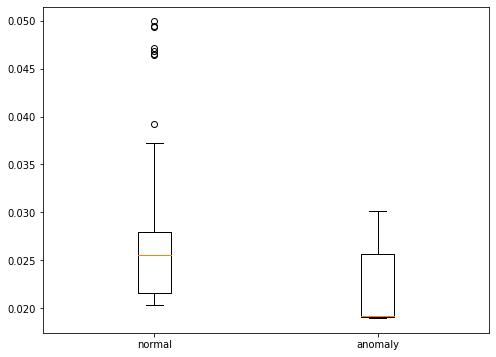

epoch [11/50], train loss:0.9358
epoch [12/50], train loss:0.8070
epoch [13/50], train loss:0.7177
epoch [14/50], train loss:0.6305
epoch [15/50], train loss:0.5343
epoch [16/50], train loss:0.4902
epoch [17/50], train loss:0.4249
epoch [18/50], train loss:0.3600
epoch [19/50], train loss:0.3080
epoch [20/50], train loss:0.2726
epoch [21/50], train loss:0.2414
epoch [22/50], train loss:0.2088
epoch [23/50], train loss:0.1791
epoch [24/50], train loss:0.1549
epoch [25/50], train loss:0.1363
epoch [26/50], train loss:0.1200
epoch [27/50], train loss:0.1040
epoch [28/50], train loss:0.0959
epoch [29/50], train loss:0.0869
epoch [30/50], train loss:0.0744
epoch [31/50], train loss:0.0705
epoch [32/50], train loss:0.0702
epoch [33/50], train loss:0.0569
epoch [34/50], train loss:0.0518
epoch [35/50], train loss:0.0482
epoch [36/50], train loss:0.0465
epoch [37/50], train loss:0.0427
epoch [38/50], train loss:0.0406
epoch [39/50], train loss:0.0392
epoch [40/50], train loss:0.0375
epoch [41/

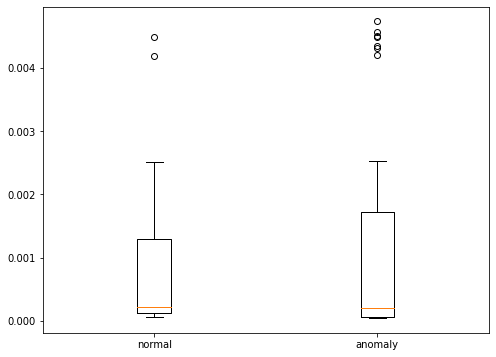

   F1_score Extraction_type  Accuracy    Recall    Dataset Model_name  \
0  0.553846       amplitude  0.673239  0.888889  MIMII_DUE    IForest   
0  0.492958       amplitude  0.594366  0.864198  MIMII_DUE        LOF   
0  0.402985       amplitude  0.774648  0.333333  MIMII_DUE      OCSVM   

   Precision  
0   0.402235  
0   0.344828  
0   0.509434  


,Extraction_type,Model_name,Accuracy,Precision,Recall,F1_score
0,amplitude,Autoencoder,0.833803,0.601852,0.802469,0.687831


In [19]:
# MIMII_DUE Anomaly detection using Autoencoders (amplitude)
toy_AE_ts = autoencoder_test(
    X_train_toy_ts,
    X_test_toy_ts,
    X_val_toy_ts,
    y_train_toy_ts,
    y_test_toy_ts,
    y_val_toy_ts,
    batch_size=64,
    lr=1e-3,
    epochs=50,
    extraction_type="amplitude",
)
toy_AE_ts